# Import Library

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# import library
import numpy as np
import pandas as pd
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **1. Data Cleaning**

The raw articles are not ready for analysis due to excessive noise. Therefore, in this step, we first clean the raw data by:  
1. drop duplicates  
2. drop Nan 
3. convert abstract to lower case  
4. remove stopwords  
5. stem  

Key words from both article titles and abstracts are extracted, which is shown in the end of this section.

In [0]:
# load the meta data from the CSV file 
df = pd.read_csv('/content/drive/My Drive/Master/MIE1624/Final_Exam/metadata.csv', usecols=['title','abstract','authors','publish_time'])

In [0]:
# this function returns True if the input string contains non-letter character
def notLetter(inputString):
  return any(not char.isalpha() for char in inputString)

# this function removes stopwords and performs stemming
def remove_stops(text, stopword, col):
  s1 = ' '
  text_str = []
  text = text[col].split(' ')
  text_arr = [value for value in text if not value in stopword]
  # text_arr = [value for value in text if not notLetter(value)]
  # stem
  ps = PorterStemmer()
  text_arr = [ps.stem(word) for word in text_arr]
  text_str.append(s1.join(text_arr))
  return text_str, text_arr

In [243]:
#drop duplicates
df = df.drop_duplicates(subset='abstract', keep="first")

#drop NANs 
df = df.dropna()

# convert abstracts to lowercase
df["title"] = df["title"].str.lower()
df["abstract"] = df["abstract"].str.lower()

# create stop words list
stopword = stopwords.words('english')

# remove stop words and number
df['title_key'] = df.apply(lambda x: remove_stops(x,stopword,'title')[0][0], axis=1)
df['abstract_key'] = df.apply(lambda x: remove_stops(x,stopword,'abstract')[0][0], axis=1)

# check for NaN, replace with space
df.fillna('', inplace= True)

df.head()

,title,abstract,publish_time,authors,title_key,abstract_key
0,siann: strain identification by alignment to n...,next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,siann: strain identif align near neighbor,next-gener sequenc increasingli use studi samp...
1,spatial epidemiology of networked metapopulati...,an emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,spatial epidemiolog network metapopulation: ov...,emerg diseas one infecti epidem caus newli tra...
2,sequencing of the human ig light chain loci fr...,germline variation at immunoglobulin gene (ig)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,sequenc human ig light chain loci hydatidiform...,germlin variat immunoglobulin gene (ig) loci c...
3,bayesian mixture analysis for metagenomic comm...,deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol,bayesian mixtur analysi metagenom commun profi...,deep sequenc clinic sampl establish tool detec...
4,mapping a viral phylogeny onto outbreak trees ...,developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,map viral phylogeni onto outbreak tree improv ...,develop method reconstruct transmiss histori v...


# **2. Exploratory Analysis**

### 2.1 Word Cloud

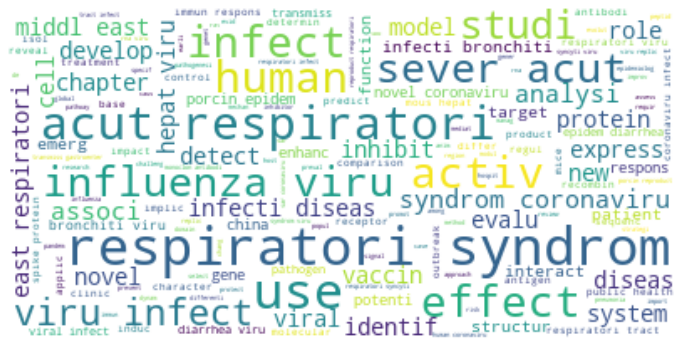

In [0]:
from wordcloud import WordCloud
stopword = stopwords.words('english')
plt.figure(figsize=(12, 10))
plt.axis("off")
words = pd.Series(df['title_key'].tolist()).str.cat(sep=' ')
word_cloud = WordCloud(stopwords=stopword,background_color='white').generate(words)
plt.imshow(word_cloud, interpolation="bilinear")
plt.show()

From the word cloud result, we can observe that most of the researched virus is respiratory related. Also, many of the papers mention the syndrom of the particularly studied virus infection, which might make it worthy to look in to related syndroms in the following steps.

### 2.2 Yearly Paper Stats

In [0]:
year_df = pd.DataFrame(index=df.index)
year_df['publish_date'] = df['publish_time']
year_df['publish_year'] = df['publish_time'].str[:4]

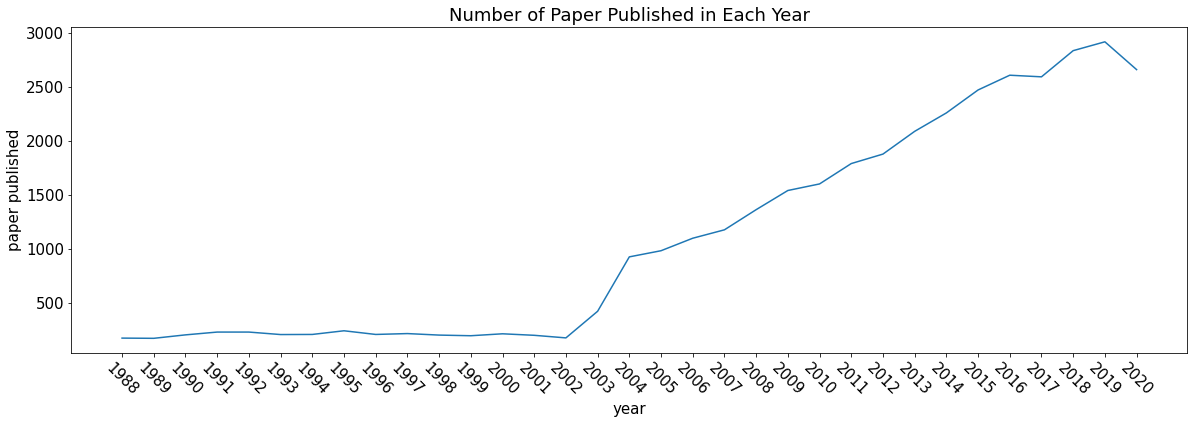

In [0]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 6))
plt.plot(year_df['publish_year'].value_counts().sort_index(ascending=True)[25:])
plt.title('Number of Paper Published in Each Year')
plt.xlabel('year')
plt.ylabel('paper published')
plt.xticks(rotation=-45)
plt.show()

From the curve, we observe that the number of researches on coronavirus suddenly increases during the year of 2002-2004, which is the period of the SARS pandemic. After that, the research area remains hot until the covid19 pandemic in 2020. The number of researches on the new covid19 is expected to bring the slope even steeper since the number of papaer published up to April has already matches the number of the entire 2018.

### 2.3 Type of Virus

This section provide statistic data on the number of paper published on each virus.

In [0]:
covid19 = ['covid19', '2019-ncov', 'wuhan','bat']
covid19_symp = ['dry cough', 'fever', 'tiredness', 'difficulty breathing', 'pneumonia', 'respiratory']
h1n1 = ['h1n1', 'swin','pig', 'porcin']
h1n1_symp = ['nasal secretion', 'chill', 'fever', 'decreased appetite']
mers = ['mers', 'middl', 'camel', 'merscov', 'saudi', 'myalgia']
mers_symp = ['fever', 'cough', 'shortness of breath',  'diarrhea']
sars = ['sar', 'sarsconv']
sars_symp = ['fever', 'discomfort', 'body ache', 'respiratory', 'diarrhea', 'dry cough', 'pneumonia']
h5n1 = ['h5n1', 'avian','chicken','bird']
h5n1_symp = ['respiratory', 'pneumonia']

In [0]:
def inlist(list1, list2):
  for item1 in list1:
    if any(item1 in item2 for item2 in list2):
      return True
  return False

def determine_virus(text):
  x = text['abstract_key'].split()
  covid19_c = 0
  h1n1_c = 0
  mers_c = 0
  sars_c = 0
  h5n1_c = 0
  names = ['covid19','h1n1','mers','sars','h5n1']
  if inlist(covid19,x):
    covid19_c = covid19_c + 1
  if inlist(h1n1,x):
    h1n1_c = h1n1_c + 1
  if inlist(mers,x):
    mers_c = mers_c + 1
  if inlist(sars,x):
    sars_c = sars_c + 1
  if inlist(h5n1,x):
    h5n1_c = h5n1_c + 1
  if np.sum([covid19_c,h1n1_c,mers_c,sars_c,h5n1_c]) == 0:
    return 'other'
  return names[np.argmax([covid19_c,h1n1_c,mers_c,sars_c,h5n1_c])]

In [0]:
df['virus'] = df.apply(lambda x: determine_virus(x), axis = 1)

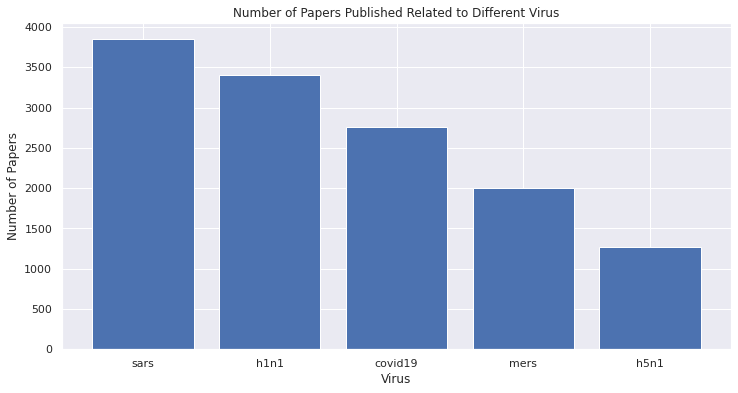

In [247]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(12, 6))
plt.title('Number of Papers Published Related to Different Virus')
plt.xlabel('Virus')
plt.ylabel('Number of Papers')
plt.bar(df['virus'].value_counts().index[1:], df['virus'].value_counts()[1:])
plt.show()

The results indicates that SARS related coronavirus has catches the most attentions of the researchers. The number of paper on covid19 is expected to excceed H1N1 very soon.

# **3. Feature Engineering**

### TF-IDF

TF-IDF transformation is performed to generate features to be fed into machine learning models. Before the transformation, any paper that is not clearly related to one of the five virus listed in section 2.3 is dropped since they provide little information for clustering. The maximum number of features is set to 1000.

In [0]:
df = df[df.virus != 'other']

In [0]:
# TF-IDF
vectorizer_TFIDF = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, analyzer='word',max_features=1000)
array_TFIDF = vectorizer_TFIDF.fit_transform(df['abstract_key'])

# **4. Clustering**  
In this section, k-Means clustering algorithm is used to group similar articles. Then, t-SNE reduction is performed in order to visualize the results of the clustering.

### 4.1 k-Means

The entire dataset is splitted into 5 clusters, which represents the five diseases mentioned in section 2.3. Idealy, some insights on the relationships between these virus can be obtained.

In [0]:
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
import pickle

In [0]:
filter_df = pd.DataFrame(array_TFIDF.toarray(), columns = vectorizer_TFIDF.get_feature_names())
filter_df = filter_df.apply(lambda x: np.where(x >100,0,x))
new_array = csr_matrix(filter_df.values)

In [344]:
# fit k-Means model
km = KMeans(n_clusters=5, init='k-means++', n_init=10, n_jobs=-1)
km.fit(new_array)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
# save model
# import pickle
# filename = '/content/drive/My Drive/Master/MIE1624/Final_Exam/kmeans_model.sav'
# pickle.dump(km, open(filename, 'wb'))

In [0]:
# load model
# filename = '/content/drive/My Drive/Master/MIE1624/Final_Exam/kmeans_model.sav'
# km = pickle.load(open(filename, 'rb'))

### 4.2 t-SNE

In [0]:
from sklearn.manifold import TSNE

In [0]:
data_stand = StandardScaler().fit_transform(new_array.toarray())

In [0]:
tsne = TSNE(verbose=1, perplexity=5)
tsne_red = tsne.fit_transform(data_stand)

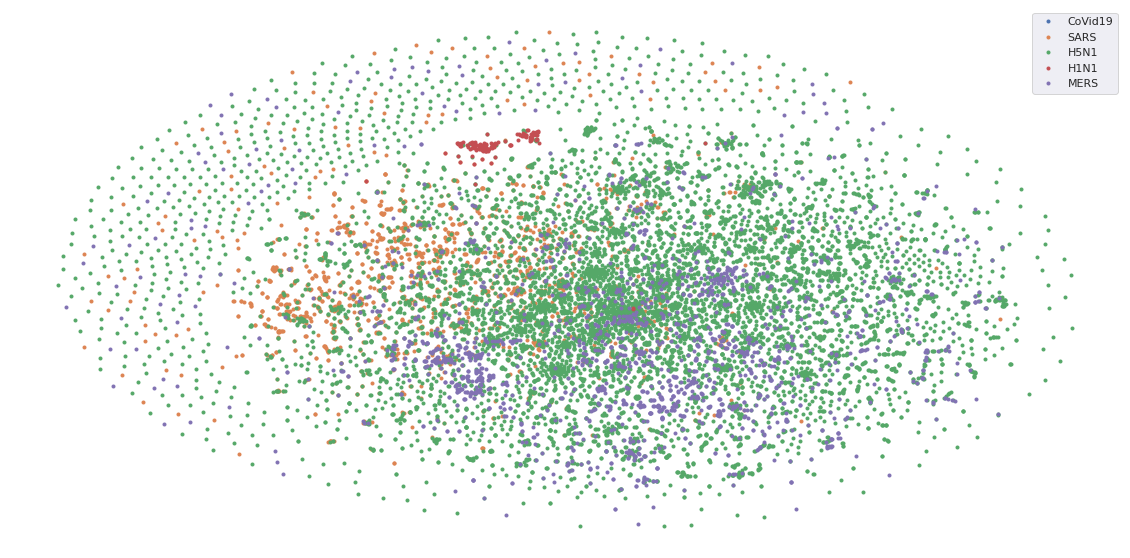

In [396]:
labels = set(km.labels_)
label_dict={
    0:'MERS',
    1:'SARS',
    2:'H1N1',
    3:'H5N1',
    4:'CoVid19'}

plt.figure(figsize=(20,10))
for i in labels:
  plt.plot(tsne_red[km.labels_==i,0], tsne_red[km.labels_==i,1], '.', label=label_dict[i])
plt.legend(['CoVid19', 'SARS', 'H5N1', 'H1N1', 'MERS'])
plt.axis('off')
plt.show()

The clusters are not clearly seperated with t-SNE, but we can observe that H1N1 is set alone. Such a cluster indicates that H1N1 differs from the other four viruses in some way. 

### 4.3 PCA
PCA dimension reduction technique is implemented in this section.

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components=2, random_state = 3).fit_transform(new_array.toarray())

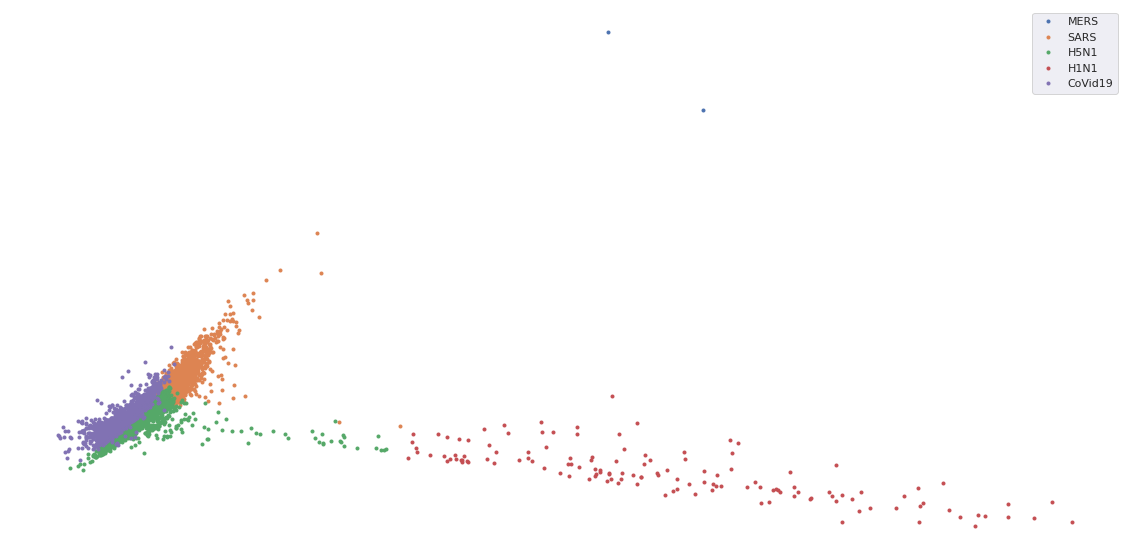

In [398]:
labels = set(km.labels_)
label_dict={
    0:'MERS',
    1:'SARS',
    2:'H1N1',
    3:'H5N1',
    4:'CoVid19'}

plt.figure(figsize=(20,10))
for i in labels:
  plt.plot(pca[km.labels_==i,0], pca[km.labels_==i,1], '.', label=label_dict[i])
plt.legend(['MERS', 'SARS', 'H5N1', 'H1N1', 'CoVid19'])
plt.axis('off')
plt.show()

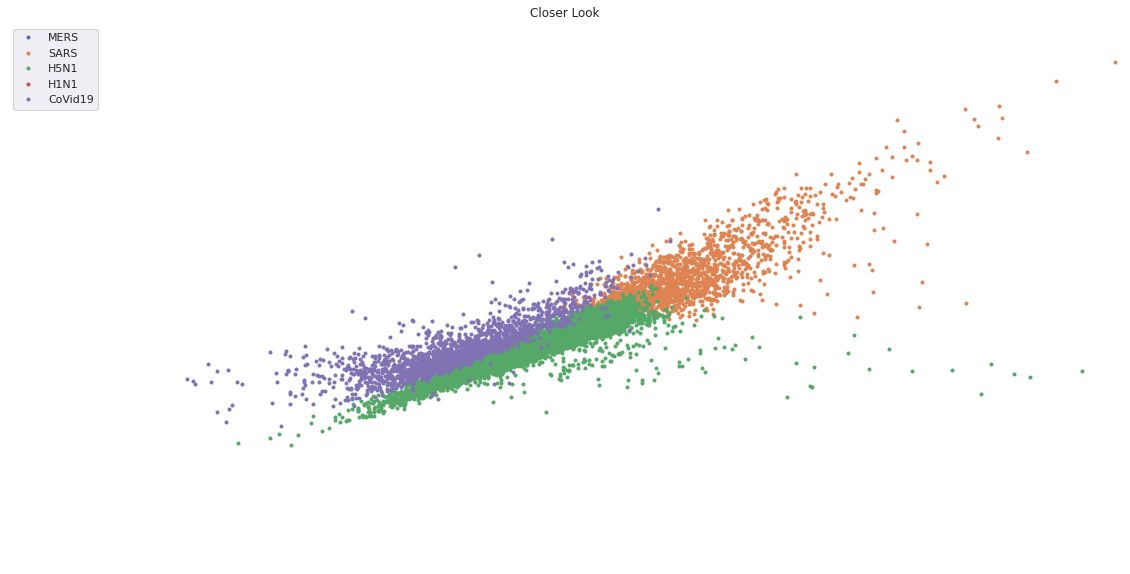

In [401]:
labels = set(km.labels_)
label_dict={
    0:'CoVid19',
    1:'SARS',
    2:'H1N1',
    3:'H5N1',
    4:'MERS'}

plt.figure(figsize=(20,10))
for i in labels:
  plt.plot(pca[km.labels_==i,0], pca[km.labels_==i,1], '.', label=label_dict[i])
plt.xlim((-20,20))
plt.ylim((-50,70))
plt.legend(['MERS', 'SARS', 'H5N1', 'H1N1', 'CoVid19'])
plt.axis('off')
plt.title('Closer Look')
plt.show()

From the above clustering, we can observe that CoVid-19, H5N1, and SARS are similar in some way, while MERS and H1N1 are more unique.

### 4.4 CoVid-19 Symptoms Dendrogram  
This section presents the dendrogram of typical symptoms of CoVid-19.

In [0]:
import scipy.cluster.hierarchy as sch

In [0]:
def cumulative_dist(symptom1, symptom2, df):
    cum_sum = 0
    number_of_papers = 0
    if symptom1 == symptom2: return 0
    
    for abstract in df['abstract']:
        if ((symptom1 in abstract) and (symptom2 in abstract)):
            number_of_papers += 1
            cum_sum -= 1
        elif (((symptom1 in abstract) and (symptom2 not in abstract)) or ((symptom1 not in abstract) and (symptom2 in abstract))):
            number_of_papers += 1
            cum_sum += 1
    return cum_sum/number_of_papers

In [276]:
symptoms = ['cold', 'fever', 'cough', 'rhinitis', 'sore throat', 'hoarseness', 'bronchitis', 'bronchiolitis', 'pneumonia', 'shortness of breath']

#Define the metric that will be used to define the "distance" metric used in the heirarchical clustering algorithm
symptom_dist = np.zeros((len(symptoms),len(symptoms)), dtype=float)
df_symptoms = pd.DataFrame(symptom_dist, columns=symptoms, index=symptoms)

symptom_dist = np.zeros((len(symptoms),len(symptoms)),float)
symptom_dist1 = np.zeros((len(symptoms),len(symptoms)),float)
#print(symptom_dist)
#print()
for i in range(len(symptoms)):
    for j in range(len(symptoms)):
        symptom_dist[i][j] = cumulative_dist(symptoms[i],symptoms[j], df)
        symptom_dist1[i][j] = cumulative_dist(symptoms[i],symptoms[j], df)**6
df_symptoms = pd.DataFrame(symptom_dist1, columns=symptoms, index=symptoms)
Y = sch.linkage(symptom_dist1, method='centroid')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  app.launch_new_instance()


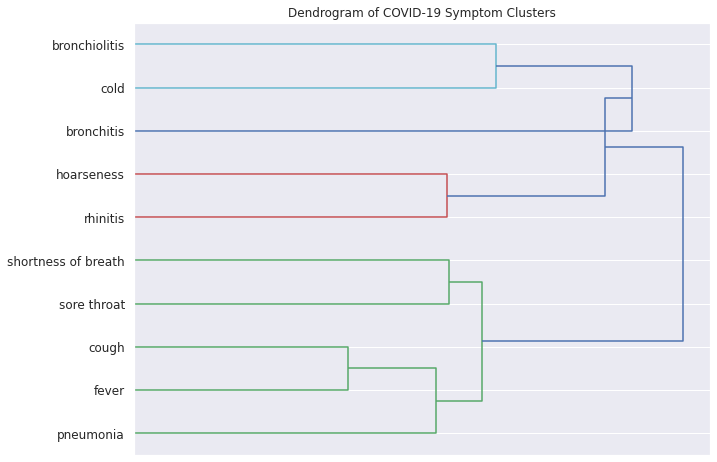

In [400]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])
# Get the dendrogram
Z1 = sch.dendrogram(Y, orientation='right')

ax1.set_xticks([])
labels = df_symptoms.columns[Z1['leaves']]
ax1.set_yticklabels(labels)
ax1.set_title("Dendrogram of COVID-19 Symptom Clusters")
plt.show()

From the above dendrogram, we can observe that cough and fever are close related, which then leads to pneumonia and shortness of breath. Such syndromes agree with the typical progression of CoVid-19 patients. The insight gained from the dengrogram is that if two closely related syndroms are observed in one person, such person has higher possibility that is infected by CoVid-19.

# **4. Insight**

The most useful insight to tackle the current covid-19 pandemic comes from the dendrogram. The community should closely monitor individuals who present two closely related syndromes, for example, cough and fever.  
  
Other than that, we observed some similarities and differences between different kinds of coronaviruses. This might provide some insight to the doctors that how to slow down the spread of the covid-19 by learning from the past experiences.